#Image Colorization Using Generative Adversarial Networks

**Student Name:-**      
Ritwik Sinha

**Student ID:-**        
220016977

**Supervisor Name:-**   
Sebastian Berns

**Aim:-**
The aim of the project is to colorize black and white images with the help of Generative Adversarial Networks. As well as predicting whether an image is real colored image or fake (artificially generated) colored image.

# Setting up the environment

In [1]:
# Mounting the colab notebook to the google drive in order to access the dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing the necessary libraries

from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)

# Loading of image dataset and conversion of them into tensors

In [3]:
# Extracting data and converting images into tensors

batch_size = 64
img_size = 120

dataset_split = 2500

master_dir = '/content/drive/MyDrive/Dogs_Dataset_1'
x = []
y = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )

# Architecture of Generator

In [4]:
# Network for the generator

def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model

# Architecture of Discriminator

In [5]:
# Network for the discriminator

def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model

# Creating loss and optimization functions

In [6]:
# Entropy, Loss functions and Optimization functions

cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.000005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.000005 )

generator = get_generator_model()
discriminator = get_discriminator_model()

# Function for training the Generative Adversarial Network (GAN) model

In [7]:
# Training of GAN

def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
        
    
    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

generator.compile(
    optimizer=generator_optimizer,
    loss=generator_loss,
    metrics=['accuracy']
)

discriminator.compile(
    optimizer=discriminator_optimizer,
    loss=discriminator_loss,
    metrics=['accuracy']
)

# Descriptive summary of generator and discriminator

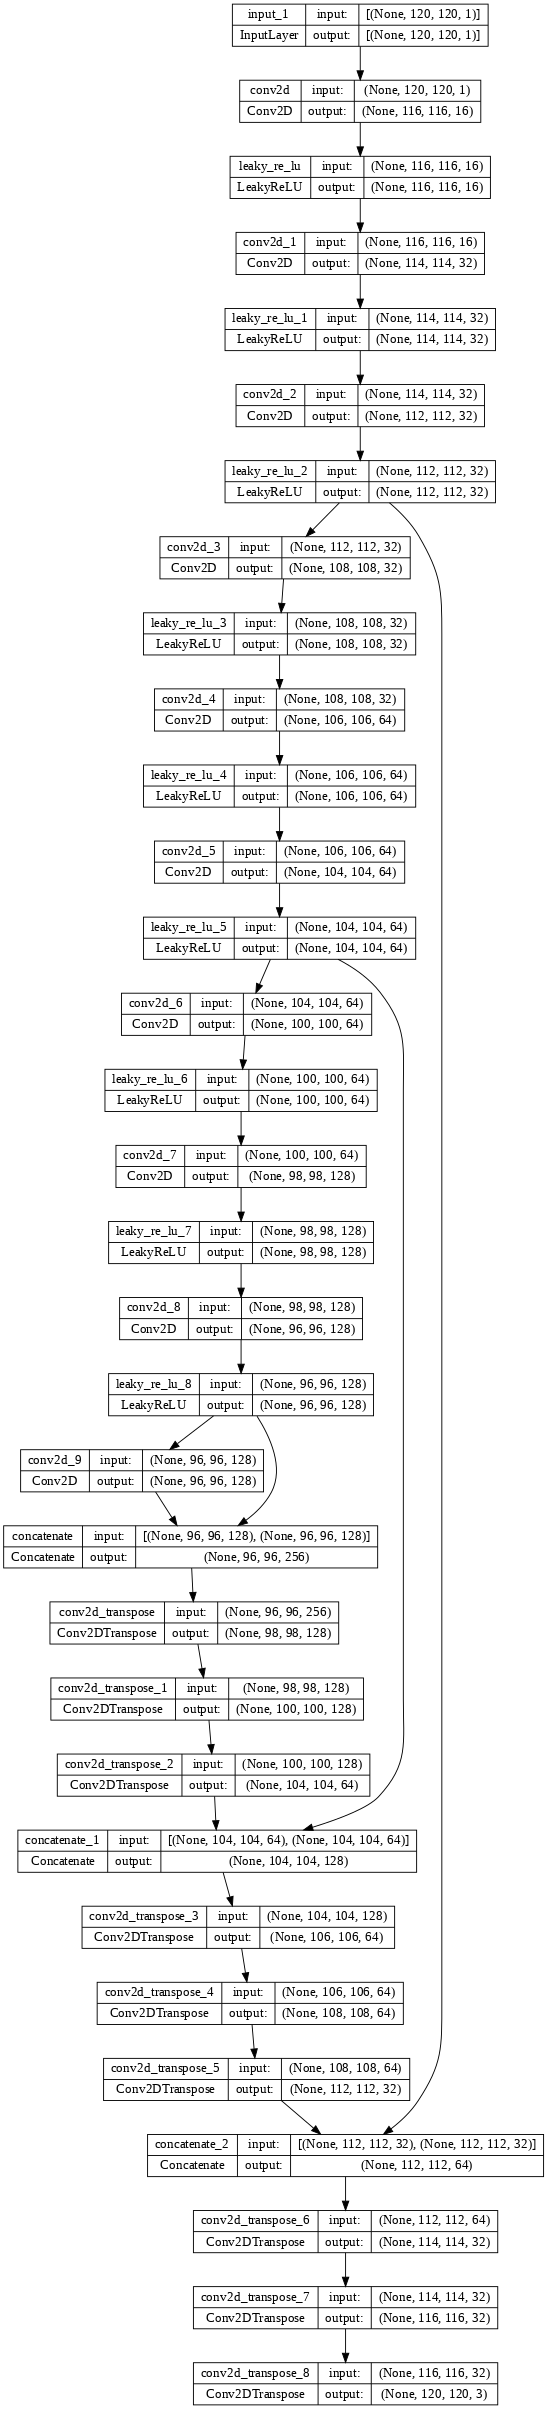

In [8]:
# Plotting the generator network

plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True, dpi=66)

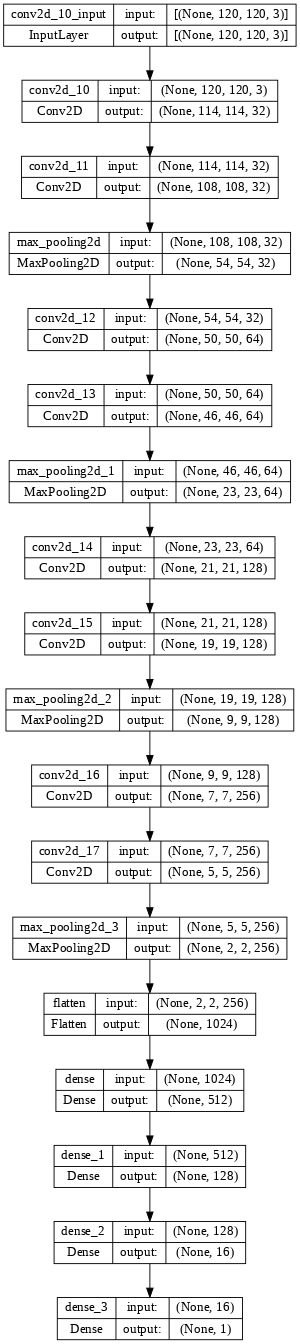

In [9]:
# Plotting the discriminator network

plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True, dpi=66)

In [10]:
# Descriptive Summary of Generator

generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 116, 116, 16  416         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 116, 116, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [11]:
# Descriptive Summary of Discriminator

discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 114, 114, 32)      4736      
                                                                 
 conv2d_11 (Conv2D)          (None, 108, 108, 32)      50208     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 32)       0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        51264     
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                    

# Executing the model and Visualising the results

In [12]:
# Running the model

history=generator.fit_generator(dataset, 
                                epochs = 15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/15
36/36 [==============================] - 75s 1s/step - loss: 0.2225 - accuracy: 0.5371
Epoch 2/15
36/36 [==============================] - 41s 1s/step - loss: 0.2071 - accuracy: 0.5177
Epoch 3/15
36/36 [==============================] - 41s 1s/step - loss: 0.1774 - accuracy: 0.3456
Epoch 4/15
36/36 [==============================] - 42s 1s/step - loss: 0.1346 - accuracy: 0.3697
Epoch 5/15
36/36 [==============================] - 42s 1s/step - loss: 0.1291 - accuracy: 0.5426
Epoch 6/15
36/36 [==============================] - 41s 1s/step - loss: 0.1273 - accuracy: 0.5433
Epoch 7/15
36/36 [==============================] - 41s 1s/step - loss: 0.1255 - accuracy: 0.5466
Epoch 8/15
36/36 [==============================] - 42s 1s/step - loss: 0.1237 - accuracy: 0.5491
Epoch 9/15
36/36 [==============================] - 41s 1s/step - loss: 0.1219 - accuracy: 0.5487
Epoch 10/15
36/36 [==============================] - 41s 1s/step - loss: 0.1203 - accuracy: 0.5470
Epoch 11/15
36/36 [

In [13]:
# Making predictions

y = generator(test_x[0:]).numpy()

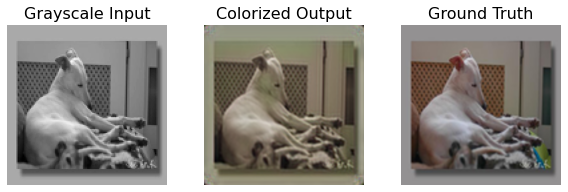

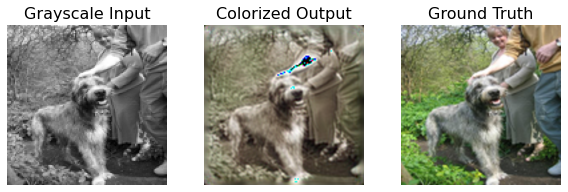

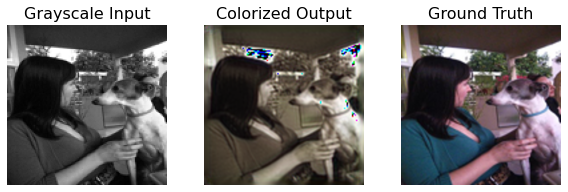

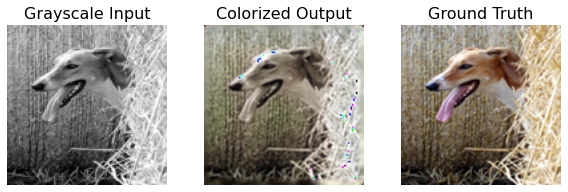

In [ ]:
# Plotting a comparative view of original colored image, grayscale image generated by the generator and the colorized image converted from the grayscale image by the generator

for i in range(11, 33, 7):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )

  plt.axis('off')

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  plt.axis('off')

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.axis('off')

  plt.show()